In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(14)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.32:59671 Dashboard: http://10.148.1.32:8787/status,Cluster Workers: 28 Cores: 112 Memory: 1400.00 GB


_______
# Global-averaged spectra

In [6]:
llc_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
ds_llc_cycl = xr.open_zarr(llc_dir+'E_cycl_all_openocean.zarr')
ds_llc_anti = xr.open_zarr(llc_dir+'E_anti_all_openocean.zarr')

E_llc_cycl = ds_llc_cycl.E_cycl_all
E_llc_anti = ds_llc_anti.E_anti_all

In [7]:
drifter_dir = '/home1/datawork/xyu/Drifters/'
ds = xr.open_zarr(drifter_dir+'mit_spec/E_drifter_globalmean.zarr')
print(ds)
E_drifter_anti = ds.E_drifter_anti
E_drifter_cycl = ds.E_drifter_cycl

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>


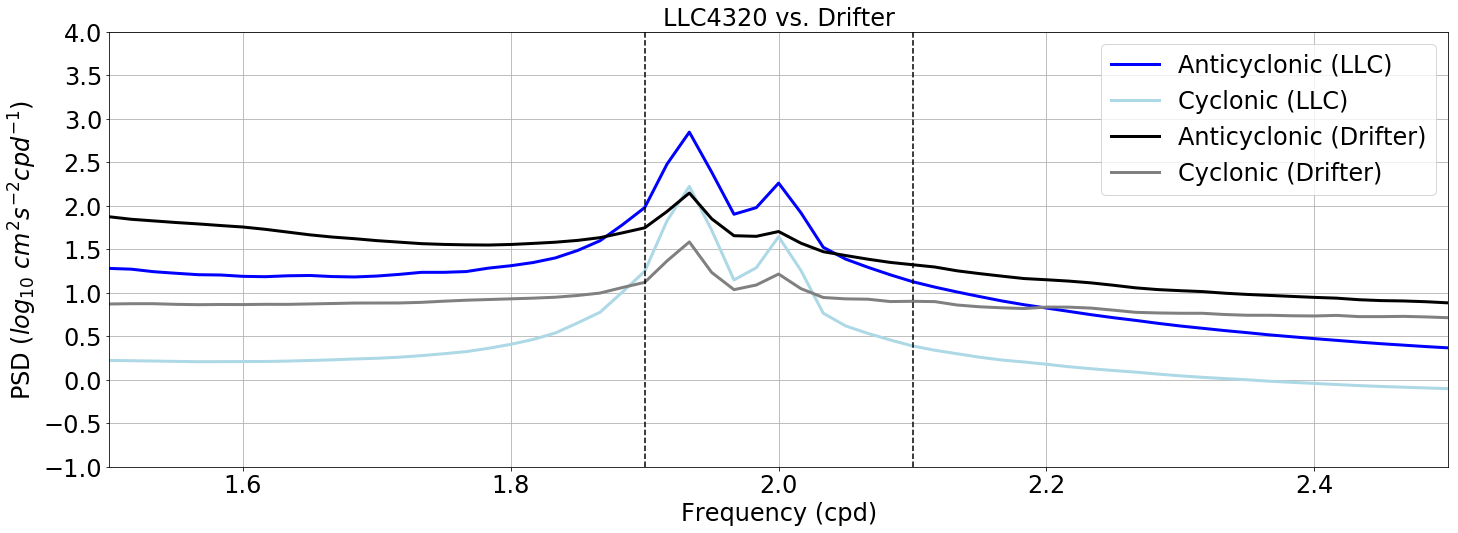

In [20]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (Drifter)', 'Cyclonic (Drifter)']

# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.,4])
ax.set_yticks([-1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([1.5,2.5])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. Drifter',fontsize=24)

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[-1,1e6],'k--') # O1
ax.plot([1,1],[-1,1e6],'k--') # S1

# Semi-diurnal frequencies
#ax.plot([1.93227,1.93227],[-1,1e6],'k--') # M2
#ax.plot([2,2],[-1,1e6],'k--') # S2

ax.plot([1.9,1.9],[-1,1e6],'k--') # M2
ax.plot([2.1,2.1],[-1,1e6],'k--') # S2



# Drifters

No handles with labels found to put in legend.


Text(0.5,1,'Drifters (linear detrend, window)')

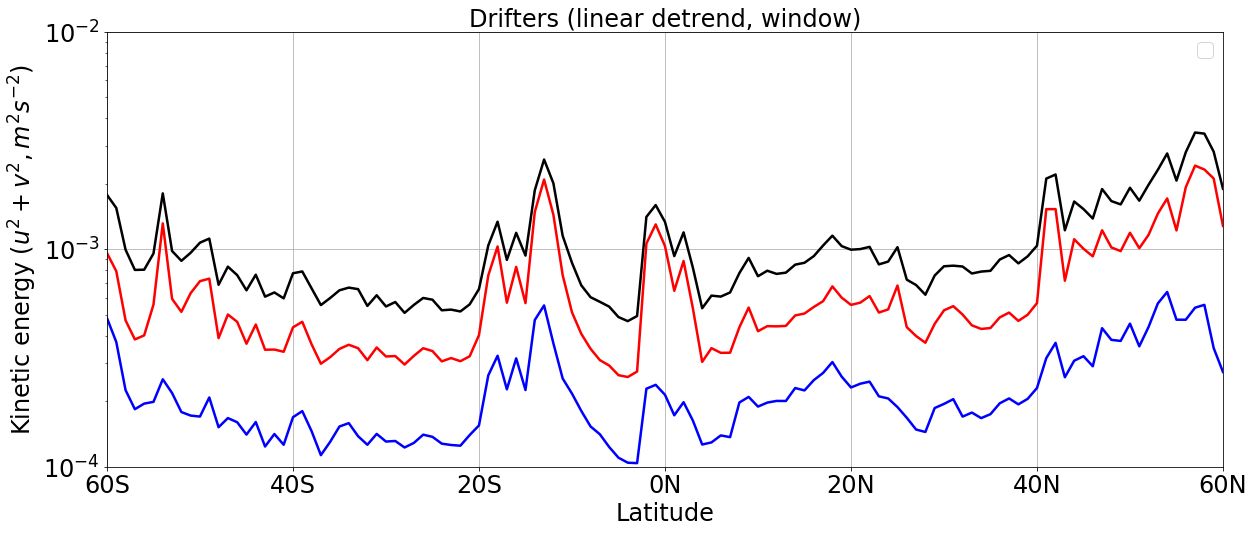

In [12]:
#

data_dir = '/home1/datawork/xyu/Drifters/'
ds_linear_window = xr.open_zarr(data_dir+'mit_spec/E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window 
df=ds_linear_window.freq_time[1]-ds_linear_window.freq_time[0]


fig, ax = plt.subplots(figsize=(20,8))

(E_drifter.where((abs(E_drifter.freq_cpd)>1.8) & (abs(E_drifter.freq_cpd)<2.2) , other=0.)*df).sum(dim='freq_time').plot(color='black', linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>1.95) & (abs(E_drifter.freq_cpd)<2.05) , other=0.)*df).sum(dim='freq_time').plot(color='blue', linewidth=2.5) # energy around semi-diurnal frequencies

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e-2])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters (linear detrend, window)',fontsize=24)

# LLC4320

In [16]:
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


No handles with labels found to put in legend.


Text(0.5,1,'LLC4320 (linear detrend, window)')

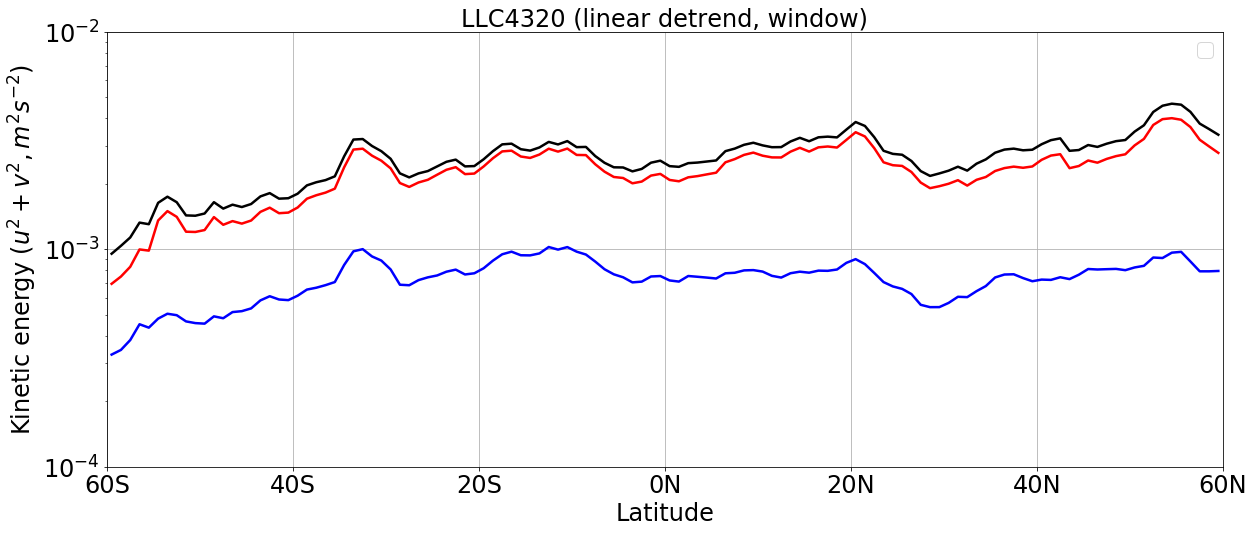

In [19]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (<0.5 cpd)', 'High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E.where((abs(E.freq_cpd)>1.8) & (abs(E.freq_cpd)<2.2) , other=0.)*df).sum(dim='freq_time').plot(color='black', linewidth=2.5) # energy around diurnal frequencies
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>1.95) & (abs(E.freq_cpd)<2.05) , other=0.)*df).sum(dim='freq_time').plot(color='blue', linewidth=2.5) # energy around diurnal frequencies


ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_yscale('log')
#ax.set_ylim([0,0.04])
ax.set_ylim([1e-4,1e-2])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (linear detrend, window)',fontsize=24)

In [22]:
cluster.scheduler.close()

<Future finished result=None>